<a href="https://colab.research.google.com/github/kundajelab/adar_editing/blob/master/xgboost_with_shap/NEIL1_XGBOOST_WITH_TREESHAP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [46]:

## Uncomment these lines if running as a google colab notebook: 
#!pip install numpy==1.15
#! git clone https://github.com/kundajelab/adar_editing
#import os
#os.chdir("adar_editing/xgboost_with_shap/")
#!pip install shap
#!pip install --upgrade xgboost
#!pip install cufflinks


In [47]:
%load_ext autoreload
%autoreload 2   

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


def configure_plotly_browser_state():
  import IPython
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              plotly: 'https://cdn.plot.ly/plotly-latest.min.js?noext',
            },
          });
        </script>
        '''))


In [48]:
#helper utilities for model training and interpretation 
import shap
from helpers import * 

#set a random seed so code is reproducible 
random.seed(1234)

# load JS visualization code to notebook
shap.initjs()
import warnings
warnings.filterwarnings('ignore')

#visualization utilities 
import matplotlib
import matplotlib.pyplot as plt 
%matplotlib inline
import chart_studio.plotly as plotly
import numpy as np
from plotly.offline import iplot
from plotly.graph_objs import Heatmap
#rom chart_studio.plotly.offline import iplot
#rom chart_studio.plotly.graph_objs import Heatmap



## Neil1 xgboost with TreeShap <a name='outline'>
<ol>
    <li><a href=#3>Computational Dataset</a></li>
    <li><a href=#4>Computational Dataset Feature Subsets</a></li>
    <li><a href=#5>Exclude mut features</a></li>
 </ol>


## Neil1 Computational features <a name='3'>
<a href=#outline>Home</a>

In [8]:
import pandas as pd 
import xgboost
#data=pd.read_csv("../xin_feature_matrices/neil1_computational.features.csv",header=0,sep=',',index_col=0)
#impute missing features 
data=pd.read_csv("../missing_feature_imputation/neil1.computational.imputed.tsv",header=0,sep='\t',index_col=0)


In [10]:
data.head()

rna_id  editing_value  free_energy  sim_nor_score  probability_active_conf  \
1       1           0.58       -41.29         0.9930                 0.137610   
2       2           0.46       -39.30         0.9125                 0.131799   
3       3           0.49       -40.32         0.9301                 0.065449   
4       4           0.48       -44.78         1.0000                 0.321958   
5       5           0.59       -41.45         0.7448                 0.169233   

   num_mutations  mut_exist  mut_pos  mut_site_dist  mut_same_as_site  ...  \
1              1          1     41.0           -6.0               0.0  ...   
2              1          1     42.0           -5.0               0.0  ...   
3              1          1     43.0           -4.0               0.0  ...   
4              1          1     44.0           -3.0               0.0  ...   
5              1          1     45.0           -2.0               0.0  ...   

   u2_5prm_cp_internal  u2_3prm_cp_internal  u3_struct  d1_struct  d2_struct  \
1                  NaN                  NaN        NaN          S          I   
2                  NaN                  NaN          S          S          I   
3                  NaN                  NaN          S          S          I   
4                  NaN                  NaN        NaN          S          I   
5                  NaN                  NaN        NaN          S          I   

   d2_5prm_cp_bulge  d2_3prm_cp_bulge  d2_5prm_cp_internal  \
1               NaN               NaN                  U:A   
2               NaN               NaN                  U:A   
3               NaN               NaN                  U:A   
4               NaN               NaN                  U:A   
5               NaN               NaN                  U:G   

   d2_3prm_cp_internal  d3_struct  
1                  G:C          S  
2                  G:C          S  
3                  G:C          S  
4                  G:C          S  
5                  C:G          S  

[5 rows x 84 columns]

In [11]:
#remove any null editing level values 
data=data[~data["editing_value"].isnull().values]

In [12]:
data=format_for_xgboost(data)
train_split,eval_split,test_split=split_train_test_eval_by_mut_pos(data)

(460, 159)
{-0.0632850493916375: 1, 0.20360732390633102: 1, 0.728370255368246: 1, 0.860450808762366: 1, 0.8695218068149521: 1, 0.871797278995544: 1, 0.919814095623327: 1, 0.9298686496387529: 1, 0.9574117859672471: 1, 0.9964567407004051: 1, 1.02331239586858: 1, 1.0443148129309199: 1, 1.0676575736099: 1, 1.09896677613689: 1, 1.19994864844643: 1, 1.2193843872360601: 1, 1.34030712556689: 1, 1.41473007488058: 1, 1.42049779340065: 1, 1.4456310293972299: 1, 1.4534068395766202: 1, 20.0: 4, 21.0: 4, 22.0: 4, 23.0: 4, 24.0: 4, 25.0: 4, 26.0: 3, 27.0: 4, 28.0: 4, 29.0: 4, 30.0: 3, 31.0: 4, 32.0: 4, 33.0: 4, 34.0: 4, 35.0: 4, 36.0: 4, 41.0: 21, 42.0: 21, 43.0: 21, 44.0: 21, 45.0: 21, 46.0: 20, 48.0: 20, 49.0: 21, 50.0: 21, 51.0: 20, 52.0: 20, 53.0: 21, 54.0: 21, 55.0: 21, 56.0: 21, 57.0: 21, 58.0: 41}


In [13]:
#Remove any non-varying features 
train_novar=get_singleval_features(train_split)
eval_novar=get_singleval_features(eval_split)
test_novar=get_singleval_features(test_split)
uniform_features_to_drop=list(set(train_novar+eval_novar+test_novar))

In [14]:
#Remove any null features 
train_null=get_all_null_features(train_split)
eval_null=get_all_null_features(eval_split)
test_null=get_all_null_features(test_split)
null_features_to_drop=list(set(train_null+eval_null+test_null))

In [15]:
to_drop=list(set(uniform_features_to_drop+null_features_to_drop))
print("\n".join(to_drop))

mut_prev_struct:B
u2_5prm_cp_hairpin:U:A
site_5prm_cp_bulge:A:U
u2_5prm_cp_bulge:A:U
d2_5prm_cp_internal:G:U
site_next_nt:C
site_3prm_cp_internal:U:A
site_struct:M
mut_ref_nt:A
d1_exist
site_1_1:A:G
site_struct:S
site_5prm_cp_hairpin:U:A
mut_prev_struct:M
u2_5prm_cp_internal:U:G
d2_3prm_cp_internal:G:U
mut_exist
d1_distance
d2_5prm_cp_bulge:A:U
d2_5prm_cp_bulge:U:G
d2_5prm_cp_internal:A:U
u2_5prm_cp_bulge:G:U
site_3prm_cp_bulge:G:C
mut_ref_nt:G
mut_ref_nt:U
d2_5prm_cp_bulge:G:U
u2_3prm_cp_bulge:A:U
d2_3prm_cp_bulge:U:A
d3_struct:S
d2_3prm_cp_bulge:G:U
site_5prm_cp_internal:A:U
mut_type:wt
site_5prm_cp_hairpin:G:C
site_5prm_cp_internal:G:C
site_next_struct:S
site_5prm_cp_hairpin:C:G
d2_5prm_cp_bulge:U:A
site_prev_struct:S
site_1_1:A:U
d3_exist
d2_3prm_cp_internal:U:A
mut_ref_struct:B
site_prev_nt:C
site_5prm_cp_internal:U:G
d1_struct:S
site_5prm_cp_bulge:G:U
d2_3prm_cp_bulge:U:G
mut_ref_struct:I
u2_5prm_cp_hairpin:U:G
site_5prm_cp_bulge:C:G
d2_exist
u2_5prm_cp_internal:C:G


In [16]:
train_split=train_split.drop(to_drop,axis=1)
eval_split=eval_split.drop(to_drop,axis=1)
test_split=test_split.drop(to_drop,axis=1)

In [17]:
train_y=train_split['editing_value']
train_X=train_split.drop(['editing_value'],axis=1)

eval_y=eval_split['editing_value']
eval_X=eval_split.drop(['editing_value'],axis=1)

test_y=test_split['editing_value']
test_X=test_split.drop(['editing_value'],axis=1)

In [18]:
print(train_X.shape)
print(train_y.shape)
print(eval_X.shape)
print(eval_y.shape)
print(test_X.shape)
print(test_y.shape)


(295, 106)
(295,)
(70, 106)
(70,)
(74, 106)
(74,)


In [19]:
## format matrixes for xgboost 
dtrain=xgboost.DMatrix(train_X,train_y)
deval=xgboost.DMatrix(eval_X,eval_y)
dtest=xgboost.DMatrix(test_X,test_y)

In [20]:
## set model training parameters 
param=dict() 
param['nthread'] = 20
#rmse -- root mean square error 
# mae -- mean absolute error 
# map -- mean average precision 
# auc -- area under ROC curve 
# aucpr -- area under precision recall curve 
param['eval_metric'] = ['auc','mae','map','aucpr','rmse']

In [21]:
evallist = [(deval, 'eval'), (dtrain, 'train')]


In [22]:
num_round = 1000
bst = xgboost.train(param, dtrain, num_round, evallist,early_stopping_rounds=10)

[0]	eval-auc:0.75021	eval-mae:0.23000	eval-map:1.00000	eval-aucpr:0.44136	eval-rmse:0.25816	train-auc:0.80118	train-mae:0.18668	train-map:1.00000	train-aucpr:0.57797	train-rmse:0.22452
Multiple eval metrics have been passed: 'train-rmse' will be used for early stopping.

Will train until train-rmse hasn't improved in 10 rounds.
[1]	eval-auc:0.74844	eval-mae:0.18003	eval-map:1.00000	eval-aucpr:0.43612	eval-rmse:0.20378	train-auc:0.80683	train-mae:0.13718	train-map:1.00000	train-aucpr:0.58810	train-rmse:0.16468
[2]	eval-auc:0.76363	eval-mae:0.14418	eval-map:1.00000	eval-aucpr:0.44250	eval-rmse:0.16691	train-auc:0.81095	train-mae:0.10249	train-map:1.00000	train-aucpr:0.59105	train-rmse:0.12257
[3]	eval-auc:0.76912	eval-mae:0.11650	eval-map:1.00000	eval-aucpr:0.45713	eval-rmse:0.14102	train-auc:0.81284	train-mae:0.07710	train-map:1.00000	train-aucpr:0.59352	train-rmse:0.09250
[4]	eval-auc:0.77550	eval-mae:0.10178	eval-map:1.00000	eval-aucpr:0.45892	eval-rmse:0.12653	train-auc:0.81422	train

[44]	eval-auc:0.79630	eval-mae:0.06024	eval-map:1.00000	eval-aucpr:0.46243	eval-rmse:0.09970	train-auc:0.81991	train-mae:0.00236	train-map:1.00000	train-aucpr:0.60164	train-rmse:0.00347
[45]	eval-auc:0.79630	eval-mae:0.06027	eval-map:1.00000	eval-aucpr:0.46243	eval-rmse:0.09972	train-auc:0.81991	train-mae:0.00231	train-map:1.00000	train-aucpr:0.60164	train-rmse:0.00342
[46]	eval-auc:0.79636	eval-mae:0.06029	eval-map:1.00000	eval-aucpr:0.46246	eval-rmse:0.09972	train-auc:0.81992	train-mae:0.00218	train-map:1.00000	train-aucpr:0.60164	train-rmse:0.00326
[47]	eval-auc:0.79636	eval-mae:0.06027	eval-map:1.00000	eval-aucpr:0.46246	eval-rmse:0.09974	train-auc:0.81992	train-mae:0.00213	train-map:1.00000	train-aucpr:0.60165	train-rmse:0.00318
[48]	eval-auc:0.79636	eval-mae:0.06025	eval-map:1.00000	eval-aucpr:0.46246	eval-rmse:0.09974	train-auc:0.81992	train-mae:0.00202	train-map:1.00000	train-aucpr:0.60165	train-rmse:0.00300
[49]	eval-auc:0.79636	eval-mae:0.06019	eval-map:1.00000	eval-aucpr:0.4

In [23]:
# save to binary file for faster loading
bst.save_model('neil1.computational.model')
# save model to text file 
bst.dump_model('neil1.computational.raw.txt')


In [24]:
## get model predictions on the test, training, and eval splits 
test_pred = bst.predict(dtest)
train_pred=bst.predict(dtrain)
eval_pred=bst.predict(deval)

In [25]:
#calculate R^2, which is representative of variance explained 
# https://datascienceplus.com/extreme-gradient-boosting-with-r/
# https://arxiv.org/pdf/1706.06060.pdf

residuals = test_y - test_pred

y_test_mean = np.mean(test_pred)
print(y_test_mean)
#calculate total sum of squares 
tss=sum((test_y-y_test_mean)*(test_y-y_test_mean))
print(tss)
# Calculate residual sum of squares
rss =  sum(residuals*residuals)
print(rss)
# Calculate R-squared
rsq  =  1 - (rss/tss)
print('The R-square of the test data is ', round(rsq,3), '\n')

0.22941455
4.56161740434029
0.7653681461361067
The R-square of the test data is  0.832 



In [26]:
## get performance metrics on full dataset 
from helpers import * 
print_aggregate_peformance_metrics(train_y,train_pred,
                                   eval_y,eval_pred,
                                   test_y,test_pred,
                                   positive_thresh=0.2)

Train
	Spearman corr : SpearmanrResult(correlation=0.99945891562907, pvalue=0.0)
	Pearson corr : (0.9999918902903421, 0.0)
	MAE : 0.0006711638088429491
	MAPE : 0.006569256892657368
	RMSE : 0.0009591356628046217
	auPRC : 0.9999625916504564
	auROC : 1.0
Eval
	Spearman corr : SpearmanrResult(correlation=0.871679432866797, pvalue=9.544103998754782e-23)
	Pearson corr : (0.8758873903585828, 3.300259217615083e-23)
	MAE : 0.0602452846909457
	MAPE : 0.5810662619536017
	RMSE : 0.09976317556942875
	auPRC : 0.9472280005277822
	auROC : 0.9600340136054422
Test
	Spearman corr : SpearmanrResult(correlation=0.8430630239605839, pvalue=4.457643219102887e-21)
	Pearson corr : (0.9139750664031588, 6.395353298933051e-30)
	MAE : 0.06091762449148407
	MAPE : 0.7135210809280893
	RMSE : 0.10169962038091915
	auPRC : 0.9514083062802049
	auROC : 0.9617404351087772


In [29]:
## Correlation values 
from scipy.stats import spearmanr,pearsonr
spearman_train=spearmanr(train_y,train_pred)
spearman_eval=spearmanr(eval_y,eval_pred)
spearman_test=spearmanr(test_y,test_pred)

pearson_train=pearsonr(train_y,train_pred)
pearson_eval=pearsonr(eval_y,eval_pred)
pearson_test=pearsonr(test_y,test_pred)

print("Spearman correlation:")
print("Train:"+str(spearman_train))
print("Eval:"+str(spearman_eval))
print("Test:"+str(spearman_test))
print("\n")
print("Pearson correlation:")
print("Train:"+str(pearson_train))
print("Eval:"+str(pearson_eval))
print("Test:"+str(pearson_test))

Spearman correlation:
Train:SpearmanrResult(correlation=0.99945891562907, pvalue=0.0)
Eval:SpearmanrResult(correlation=0.871679432866797, pvalue=9.544103998754782e-23)
Test:SpearmanrResult(correlation=0.8430630239605839, pvalue=4.457643219102887e-21)


Pearson correlation:
Train:(0.9999918902903421, 0.0)
Eval:(0.8758873903585828, 3.300259217615083e-23)
Test:(0.9139750664031588, 6.395353298933051e-30)


In [30]:
## MAE
from sklearn.metrics import mean_absolute_error
mae_train=mean_absolute_error(train_y,train_pred)
print("MAE Train:"+str(mae_train))

mae_eval=mean_absolute_error(eval_y,eval_pred)
print("MAE Eval:"+str(mae_eval))

mae_test=mean_absolute_error(test_y,test_pred)
print("MAE Test:"+str(mae_test))


MAE Train:0.0006711638088429491
MAE Eval:0.0602452846909457
MAE Test:0.06091762449148407


In [31]:
## MAPE
pseudocount=0.01
mape_train=np.mean(np.abs((train_y - train_pred) /(pseudocount+train_y))) * 100
print("MAPE Train:"+str(mape_train)+"%")

mape_eval=np.mean(np.abs((eval_y - eval_pred) /(pseudocount+eval_y))) * 100
print("MAPE Eval:"+str(mape_eval)+"%")

mape_test=np.mean(np.abs((test_y - test_pred) /(pseudocount+test_y))) * 100
print("MAPE Test:"+str(mape_test)+"%")

MAPE Train:0.6569256892657368%
MAPE Eval:58.106626195360164%
MAPE Test:71.35210809280893%


In [32]:
## RMSE
from sklearn.metrics import mean_squared_error
import math 
rmse_train=math.sqrt(mean_squared_error(train_y,train_pred))
print("RMSE Train:"+str(rmse_train))

rmse_eval=math.sqrt(mean_squared_error(eval_y,eval_pred))
print("RMSE Eval:"+str(rmse_eval))

rmse_test=math.sqrt(mean_squared_error(test_y,test_pred))
print("RMSE Test:"+str(rmse_test))


RMSE Train:0.0009591356628046217
RMSE Eval:0.09976317556942875
RMSE Test:0.10169962038091915


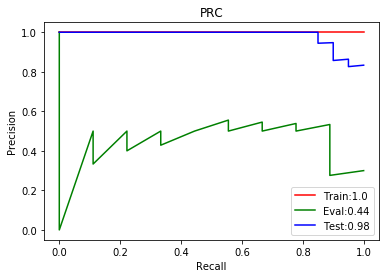

In [33]:
## PRC 
## PRC only valid for binary outcomes. 
## Editing levels < 0.5 are labeled as "0". 
## Editing levels >= 0.5 are labeled as "1". 

from sklearn.metrics import auc, precision_recall_curve

precision_train,recall_train,prc_thresholds_train=precision_recall_curve(train_y>=0.5,train_pred)
precision_eval,recall_eval,prc_thresholds_eval=precision_recall_curve(eval_y>=0.5,eval_pred)
precision_test,recall_test,prc_thresholds_test=precision_recall_curve(test_y>=0.5,test_pred)

auprc_train=auc(recall_train,precision_train)
auprc_eval=auc(recall_eval,precision_eval)
auprc_test=auc(recall_test,precision_test)

plt.plot(recall_train,precision_train,'r',label="Train:"+str(round(auprc_train,2)))
plt.plot(recall_eval,precision_eval,'g',label="Eval:"+str(round(auprc_eval,2)))
plt.plot(recall_test,precision_test,'b',label="Test:"+str(round(auprc_test,2)))
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("PRC")
plt.legend()

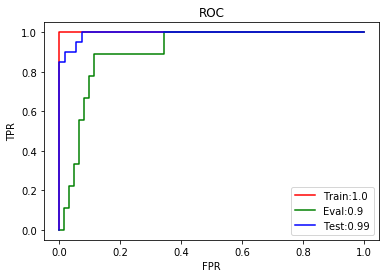

In [34]:
## ROC
from sklearn.metrics import roc_curve, roc_auc_score
fpr_train,tpr_train,roc_thresholds_train=roc_curve(train_y>=0.5,train_pred)
fpr_eval,tpr_eval,roc_thresholds_eval=roc_curve(eval_y>=0.5,eval_pred)
fpr_test,tpr_test,roc_thresholds_test=roc_curve(test_y>=0.5,test_pred)

auroc_train=roc_auc_score(train_y>=0.5,train_pred)
auroc_eval=roc_auc_score(eval_y>=0.5,eval_pred)
auroc_test=roc_auc_score(test_y>=0.5,test_pred)

plt.plot(fpr_train,tpr_train,'r',label="Train:"+str(round(auroc_train,2)))
plt.plot(fpr_eval,tpr_eval,'g',label="Eval:"+str(round(auroc_eval,2)))
plt.plot(fpr_test,tpr_test,'b',label="Test:"+str(round(auroc_test,2)))
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC")
plt.legend()

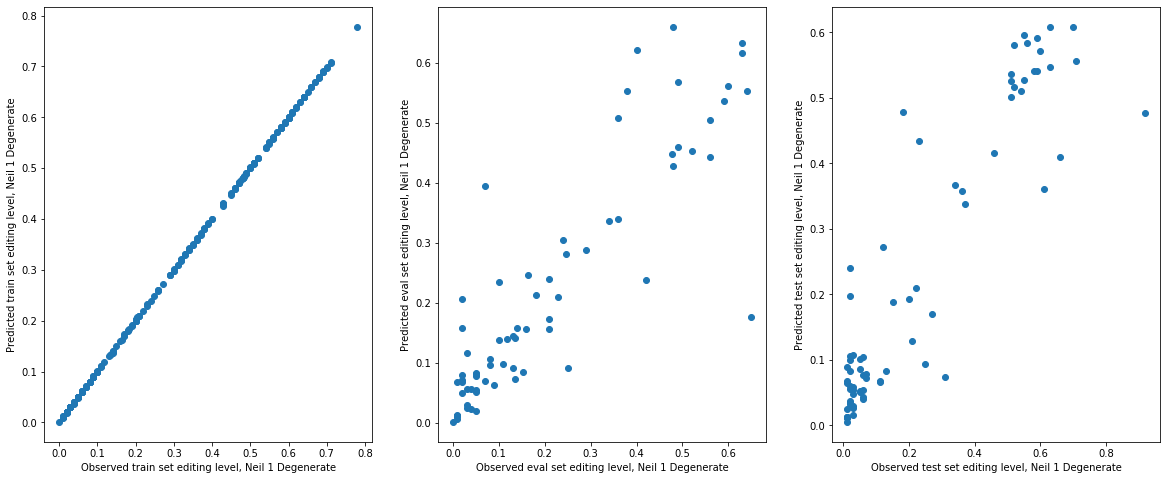

In [35]:
#plot the test set predictions 
matplotlib.rcParams['figure.figsize'] = [20, 8]
plt.subplot(1,3,1)
plt.plot(list(train_y),list(train_pred),'o')
plt.xlabel("Observed train set editing level, Neil 1 Degenerate")
plt.ylabel("Predicted train set editing level, Neil 1 Degenerate")
plt.subplot(1,3,2)
plt.plot(list(eval_y),list(eval_pred),'o')
plt.xlabel("Observed eval set editing level, Neil 1 Degenerate")
plt.ylabel("Predicted eval set editing level, Neil 1 Degenerate")
plt.subplot(1,3,3)
plt.plot(list(test_y),list(test_pred),'o')
plt.xlabel("Observed test set editing level, Neil 1 Degenerate")
plt.ylabel("Predicted test set editing level, Neil 1 Degenerate")

plt.show()

In [36]:
import plotnine
from plotnine import *
test_df=pd.DataFrame({'Observed':test_y,
                     'Predicted':test_pred,
                     'Dataset':'NEIL1_COMP'})

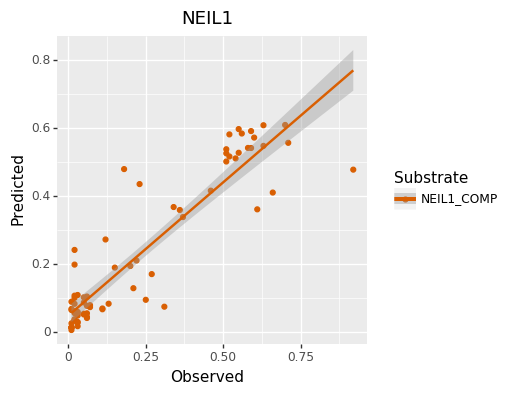

<ggplot: (8770835572969)>


In [38]:
plotnine.options.figure_size = (4, 4)

p=(ggplot(test_df, aes('Observed', 'Predicted', color='factor(Dataset)'))
 + geom_point()
 + stat_smooth(method='lm')
 + scale_color_manual(values=['#d95f02'],name="Substrate")
 + ggtitle("NEIL1"))
print(p)
ggsave(plot=p, filename='NEIL1.comp.substrate.svg',width=4,height=4,units='in')


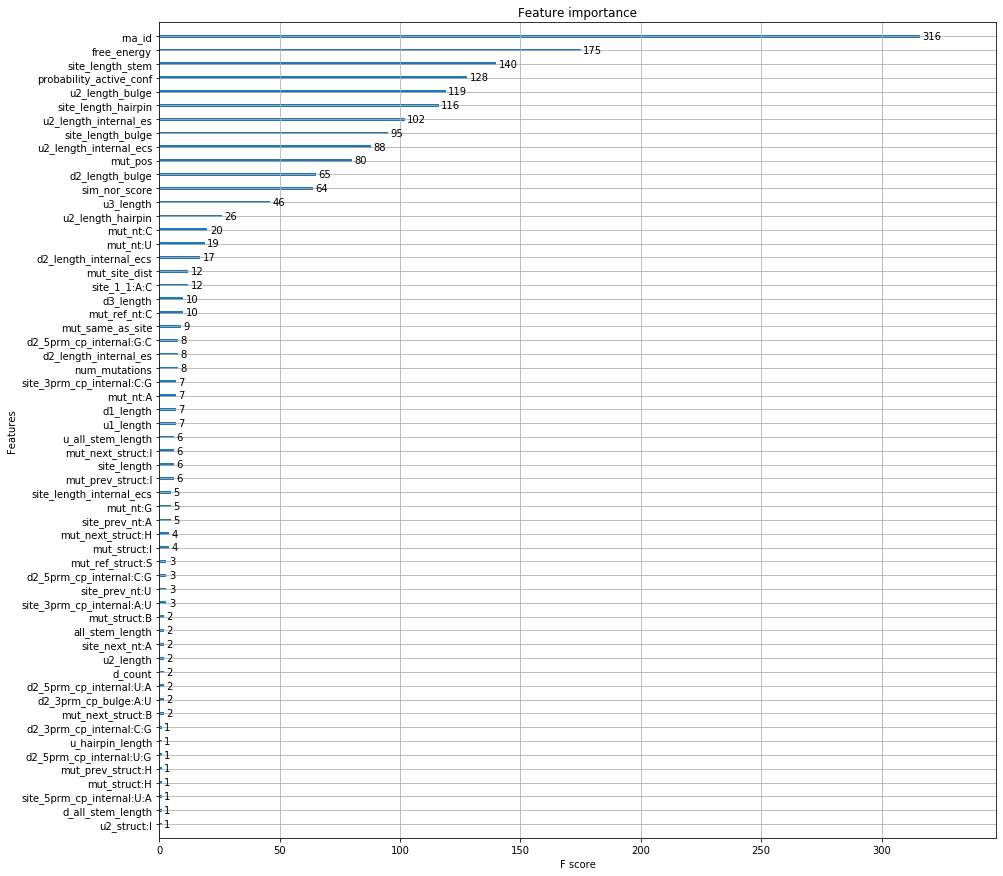

In [39]:
matplotlib.rcParams['figure.figsize'] = [15, 15]
xgboost.plot_importance(bst)

In [40]:
xgboost.to_graphviz(bst, num_trees=2)


ImportError: You must install graphviz to plot tree

In [41]:
# explain the model's predictions using SHAP values
explainer = shap.TreeExplainer(bst)
shap_values = explainer.shap_values(test_X)
shap_values.shape

(74, 106)

In [42]:
shap.force_plot

<function shap.plots.force.force_plot(base_value, shap_values, features=None, feature_names=None, out_names=None, link='identity', plot_cmap='RdBu', matplotlib=False, show=True, figsize=(20, 3), ordering_keys=None, ordering_keys_time_format=None, text_rotation=0)>

In [43]:
test_X.iloc[6,:].shape

(106,)

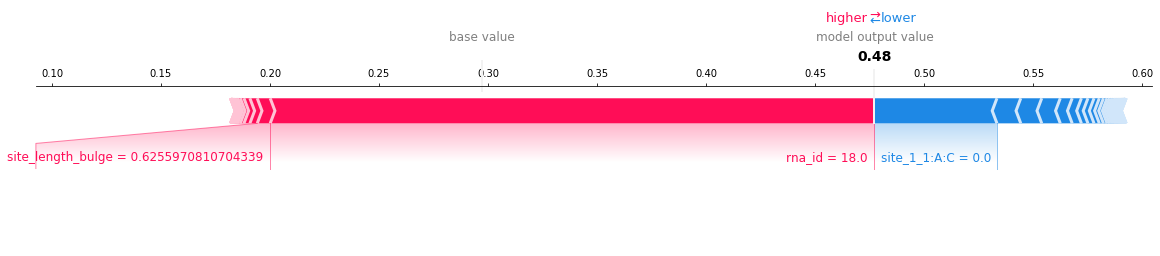

In [44]:
test_y=pd.DataFrame(test_y)
max_index=test_y.index[test_y['editing_value'] == max(test_y['editing_value'])]
max_row=test_y.index.get_loc(max_index[0])
# visualize prediction for isoform with the highest editing level 
# visualize prediction for isoform with the highest editing level 
shap.initjs()
matplotlib=True
shap.force_plot(explainer.expected_value, shap_values[max_row,:], test_X.iloc[max_row,:],matplotlib=True,show=False)
plt.savefig("NEIL1.comp.visualize_prediction.highest.svg", format='svg', width=7, height=1, dpi=300, bbox_inches="tight")

In [45]:
 max(test_y['editing_value'])

0.92

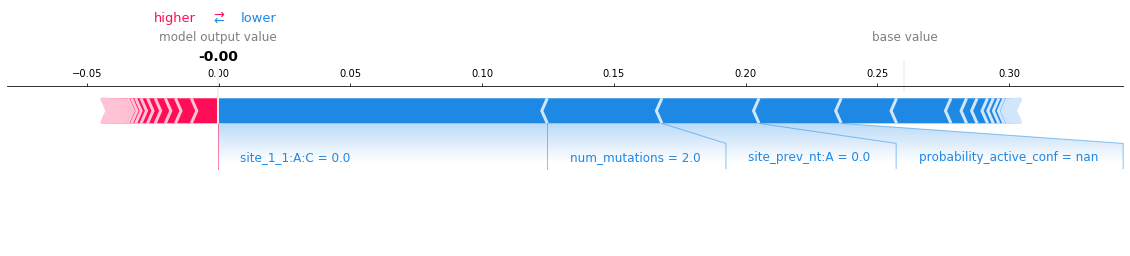

In [39]:
# visualize prediction for isoform with the lowest editing level 
shap.initjs()
min_index=test_y.index[test_y['editing_value'] == min(test_y['editing_value'])]
min_row=test_y.index.get_loc(min_index[0])
matplotlib=True
shap.force_plot(explainer.expected_value, shap_values[min_row,:], test_X.iloc[min_row,:],matplotlib=True,show=False)
plt.savefig("NEIL1.comp.visualize_prediction.lowest.svg", format='svg', width=7, height=1, dpi=300, bbox_inches="tight")

In [62]:
 min(test_y['editing_value'])

0.0

In [40]:
# visualize the training set predictions
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values,train_X)

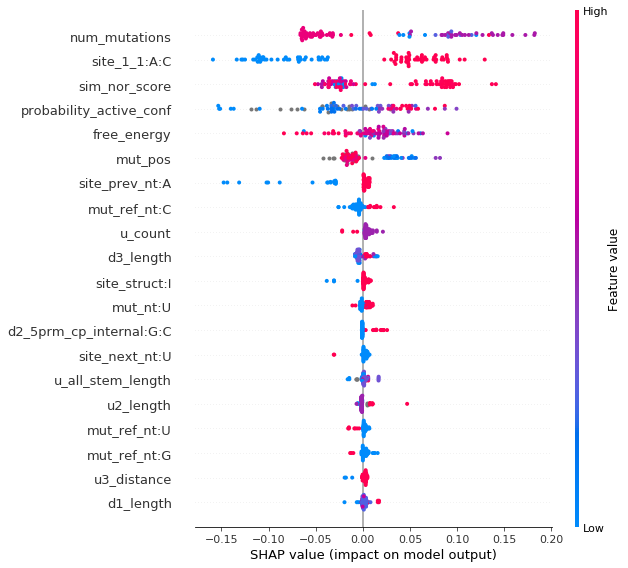

In [41]:
# summarize the effect of all the features 
shap.summary_plot(shap_values, test_X,show=False)
plt.savefig("NEIL1.comp.shap.svg", format='svg',width=20,height=10,dpi=300,bbox_inches="tight")


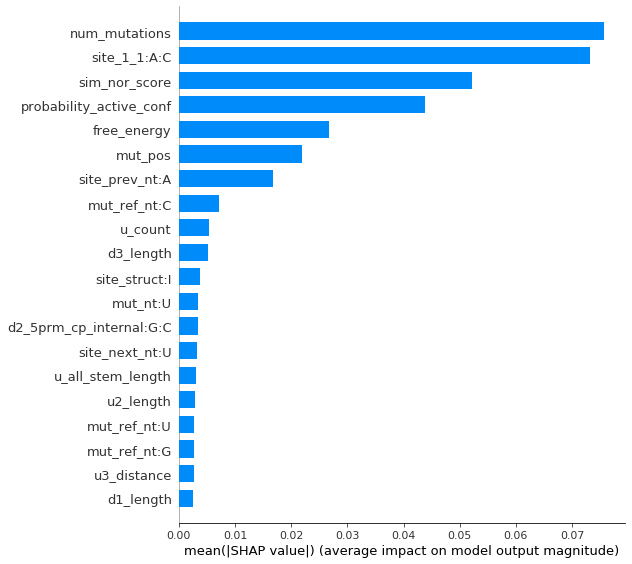

In [42]:
# We can also just take the mean absolute value of the SHAP values for each feature 
# to get a standard bar plot (produces stacked bars for multi-class outputs):
shap.summary_plot(shap_values, test_X, plot_type="bar")

In [43]:
mean_abs_shap_vals=np.mean(abs(shap_values),axis=0)
features=test_X.columns
shap_dict=pd.DataFrame({'feature':features,
          'mean_abs_shap':mean_abs_shap_vals})
shap_dict.to_csv("NEIL1_comp_shap_mean_abs.txt",index=False,sep='\t')

In [44]:
shap_dict

feature  mean_abs_shap
0                free_energy       0.026694
1              sim_nor_score       0.052229
2    probability_active_conf       0.043819
3              num_mutations       0.075681
4                  mut_exist       0.000008
..                       ...            ...
100  d2_3prm_cp_internal:U:A       0.000000
101  d2_3prm_cp_internal:U:G       0.000000
102              d3_distance       0.001601
103                d3_length       0.005275
104           d3_length_stem       0.000000

[105 rows x 2 columns]

In [45]:
## Compute pairwise interaction values from TreeShap
shap_interaction_values=explainer.shap_interaction_values(test_X)
shap_interaction_values.shape

(87, 105, 105)

In [46]:
##Average interaction values across the datapoints in the test set 
mean_interaction_values=np.mean(shap_interaction_values,axis=0)

In [47]:
Index=test_X.columns
Cols=test_X.columns
mean_interaction_values_df = pd.DataFrame(mean_interaction_values, index=Index, columns=Cols)

In [48]:
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)
configure_plotly_browser_state()

trace = Heatmap(z=mean_interaction_values_df.values,
                   x=Cols,
                   y=Index)
iplot([trace],show_link=False)


## Computational Dataset: Feature Subsets<a name='4'>
<a href=#outline>Home</a>

In [49]:
shap_values=pd.DataFrame(shap_values,columns=Cols)

['site_prev_nt*', 'site_next_nt*']


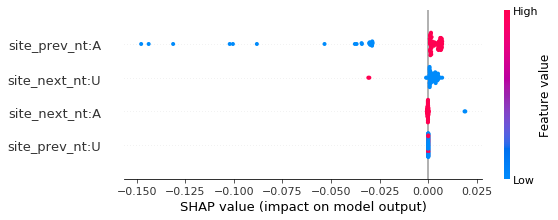

Contribution/Total:0.05295215
['free_energy*', 'sim_nor_score*', 'probability_active_conf*']


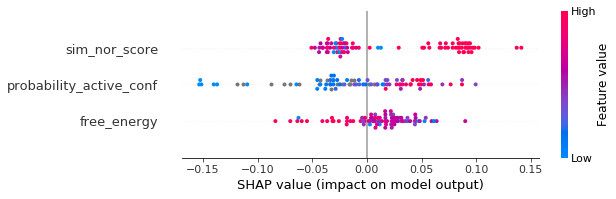

Contribution/Total:0.3152962
['u1_exist*', 'u1_distance*', 'u1_struct*', 'u1_length*', 'u1_length_stem*', 'u1_length_hairpin*', 'u1_length_bulge*', 'u1_length_internal_es*', 'u1_length_internal_ecs*', 'u1_5prm_cp_hairpin*', 'u1_5prm_cp_bulge*', 'u1_3prm_cp_bulge*', 'u1_5prm_cp_internal*', 'u1_3prm_cp_internal*', 'd1_exist*', 'd1_distance*', 'd1_struct*', 'd1_length*', 'd1_length_stem*', 'd1_length_hairpin*', 'd1_length_bulge*', 'd1_length_internal_es*', 'd1_length_internal_ecs*', 'd1_5prm_cp_hairpin*', 'd1_5prm_cp_bulge*', 'd1_3prm_cp_bulge*', 'd1_5prm_cp_internal*', 'd1_3prm_cp_internal*']


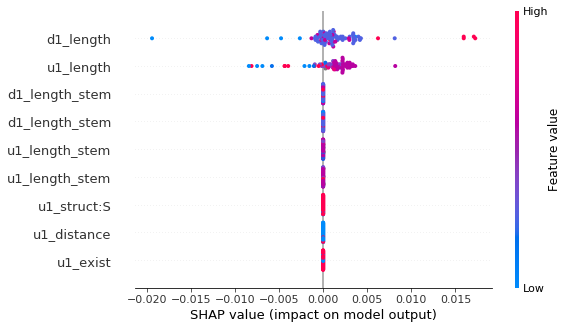

Contribution/Total:0.01209861
['num_mutations*', 'mut_pos*', 'mut_site_dist*', 'mut_ref_nt*', 'mut_nt*', 'mut_struct*', 'mut_ref_struct*', 'mut_prev_struct*', 'mut_next_struct*', 'mut_same_as_site*']


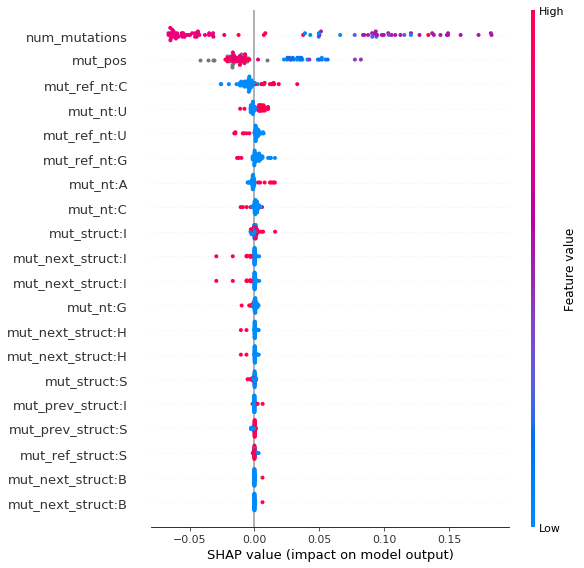

Contribution/Total:0.32279545
['site_prev_nt*', 'site_next_nt*', 'site_struct*', 'site_prev_struct*', 'site_next_struct*', 'site_1_1*', 'site_length*', 'site_length_stem*', 'site_length_hairpin*', 'site_length_bulge*', 'site_length_internal_es*', 'site_length_internal_ecs*', 'site_5prm_cp_hairpin*', 'site_5prm_cp_bulge*', 'site_3prm_cp_bulge*', 'site_5prm_cp_internal*', 'site_3prm_cp_internal*']


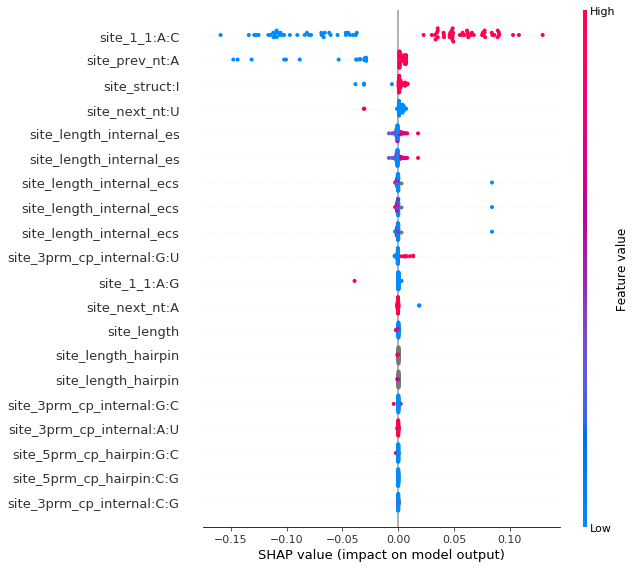

Contribution/Total:0.27831158
['u_count*', 'u_all_stem_length*', 'u_hairpin_length*', 'u1_exist*', 'u1_distance*', 'u1_struct*', 'u1_length*', 'u1_length_stem*', 'u1_length_hairpin*', 'u1_length_bulge*', 'u1_length_internal_es*', 'u1_length_internal_ecs*', 'u1_5prm_cp_hairpin*', 'u1_5prm_cp_bulge*', 'u1_3prm_cp_bulge*', 'u1_5prm_cp_internal*', 'u1_3prm_cp_internal*', 'u2_exist*', 'u2_distance*', 'u2_struct*', 'u2_length*', 'u2_length_stem*', 'u2_length_hairpin*', 'u2_length_bulge*', 'u2_length_internal_es*', 'u2_length_internal_ecs*', 'u2_5prm_cp_hairpin*', 'u2_5prm_cp_bulge*', 'u2_3prm_cp_bulge*', 'u2_5prm_cp_internal*', 'u2_3prm_cp_internal*', 'u3_exist*', 'u3_distance*', 'u3_struct*', 'u3_length*', 'u3_length_stem*', 'u3_length_hairpin*', 'u3_length_bulge*', 'u3_length_internal_es*', 'u3_length_internal_ecs*', 'u3_5prm_cp_hairpin*', 'u3_5prm_cp_bulge*', 'u3_3prm_cp_bulge*', 'u3_5prm_cp_internal*', 'u3_3prm_cp_internal*']


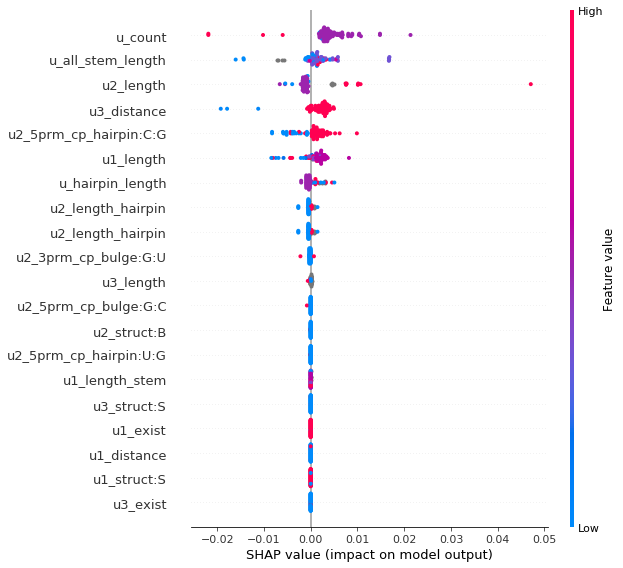

Contribution/Total:0.05258834
['d_count*', 'd_all_stem_length*', 'd1_exist*', 'd1_distance*', 'd1_struct*', 'd1_length*', 'd1_length_stem*', 'd1_length_hairpin*', 'd1_length_bulge*', 'd1_length_internal_es*', 'd1_length_internal_ecs*', 'd1_5prm_cp_hairpin*', 'd1_5prm_cp_bulge*', 'd1_3prm_cp_bulge*', 'd1_5prm_cp_internal*', 'd1_3prm_cp_internal*', 'd2_exist*', 'd2_distance*', 'd2_struct*', 'd2_length*', 'd2_length_stem*', 'd2_length_hairpin*', 'd2_length_bulge*', 'd2_length_internal_es*', 'd2_length_internal_ecs*', 'd2_5prm_cp_hairpin*', 'd2_5prm_cp_bulge*', 'd2_3prm_cp_bulge*', 'd2_5prm_cp_internal*', 'd2_3prm_cp_internal*', 'd3_exist*', 'd3_distance*', 'd3_struct*', 'd3_length*', 'd3_length_stem*', 'd3_length_hairpin*', 'd3_length_bulge*', 'd3_length_internal_es*', 'd3_length_internal_ecs*', 'd3_5prm_cp_hairpin*', 'd3_5prm_cp_bulge*', 'd3_3prm_cp_bulge*', 'd3_5prm_cp_internal*', 'd3_3prm_cp_internal*']


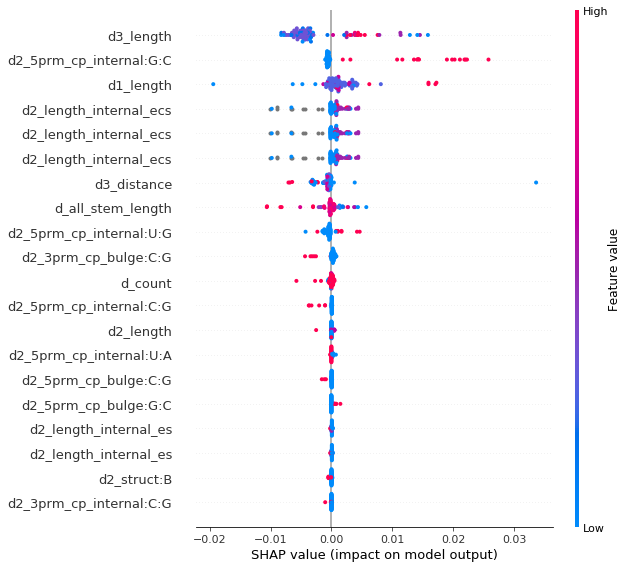

Contribution/Total:0.0544599
['u_count*', 'u_all_stem_length*', 'u_hairpin_length*', 'u1_exist*', 'u1_distance*', 'u1_struct*', 'u1_length*', 'u1_length_stem*', 'u1_length_hairpin*', 'u1_length_bulge*', 'u1_length_internal_es*', 'u1_length_internal_ecs*', 'u1_5prm_cp_hairpin*', 'u1_5prm_cp_bulge*', 'u1_3prm_cp_bulge*', 'u1_5prm_cp_internal*', 'u1_3prm_cp_internal*', 'u2_exist*', 'u2_distance*', 'u2_struct*', 'u2_length*', 'u2_length_stem*', 'u2_length_hairpin*', 'u2_length_bulge*', 'u2_length_internal_es*', 'u2_length_internal_ecs*', 'u2_5prm_cp_hairpin*', 'u2_5prm_cp_bulge*', 'u2_3prm_cp_bulge*', 'u2_5prm_cp_internal*', 'u2_3prm_cp_internal*', 'u3_exist*', 'u3_distance*', 'u3_struct*', 'u3_length*', 'u3_length_stem*', 'u3_length_hairpin*', 'u3_length_bulge*', 'u3_length_internal_es*', 'u3_length_internal_ecs*', 'u3_5prm_cp_hairpin*', 'u3_5prm_cp_bulge*', 'u3_3prm_cp_bulge*', 'u3_5prm_cp_internal*', 'u3_3prm_cp_internal*', 'd_count*', 'd_all_stem_length*', 'd1_exist*', 'd1_distance*', 

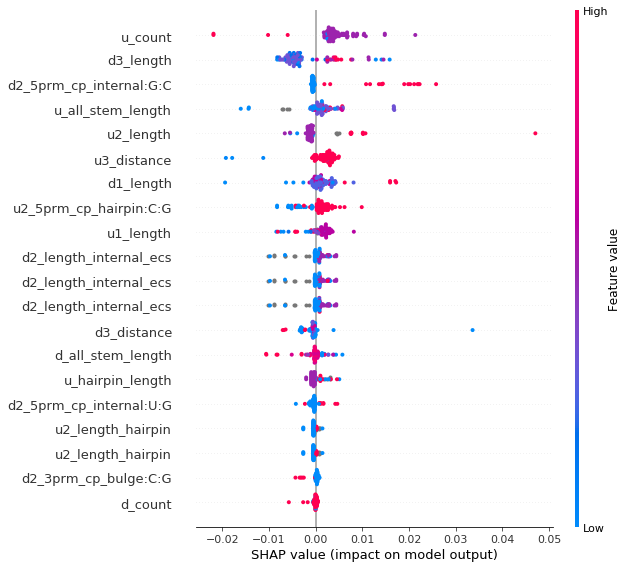

Contribution/Total:0.10704824
['num_mutations*', 'mut_pos*', 'mut_site_dist*', 'mut_ref_nt*', 'mut_nt*', 'mut_struct*', 'mut_ref_struct*', 'mut_prev_struct*', 'mut_next_struct*', 'mut_same_as_site*', 'site_prev_nt*', 'site_next_nt*', 'site_struct*', 'site_prev_struct*', 'site_next_struct*', 'site_1_1*', 'site_length*', 'site_length_stem*', 'site_length_hairpin*', 'site_length_bulge*', 'site_length_internal_es*', 'site_length_internal_ecs*', 'site_5prm_cp_hairpin*', 'site_5prm_cp_bulge*', 'site_3prm_cp_bulge*', 'site_5prm_cp_internal*', 'site_3prm_cp_internal*']


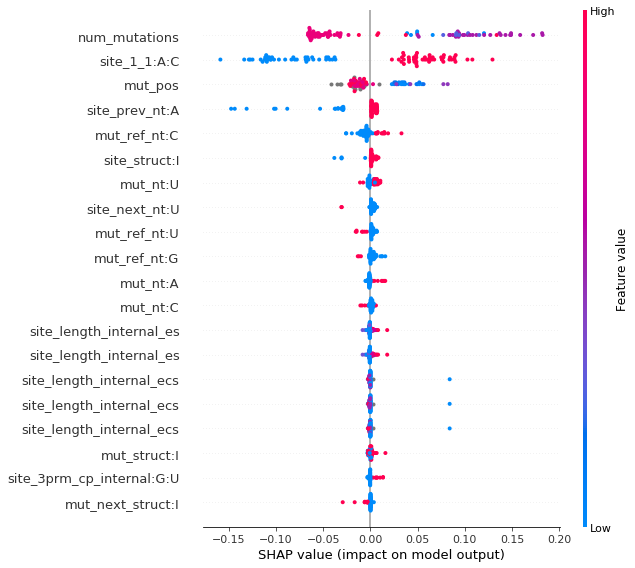

Contribution/Total:0.601107
['all_stem_length', 'free_energy*', 'sim_nor_score*', 'probability_active_conf*', 'num_mutations*', 'mut_pos*', 'mut_site_dist*', 'mut_ref_nt*', 'mut_nt*', 'mut_struct*', 'mut_ref_struct*', 'mut_prev_struct*', 'mut_next_struct*', 'mut_same_as_site*', 'site_prev_nt*', 'site_next_nt*', 'site_struct*', 'site_prev_struct*', 'site_next_struct*', 'site_1_1*', 'site_length*', 'site_length_stem*', 'site_length_hairpin*', 'site_length_bulge*', 'site_length_internal_es*', 'site_length_internal_ecs*', 'site_5prm_cp_hairpin*', 'site_5prm_cp_bulge*', 'site_3prm_cp_bulge*', 'site_5prm_cp_internal*', 'site_3prm_cp_internal*', 'd_count*', 'd_all_stem_length*', 'd1_exist*', 'd1_distance*', 'd1_struct*', 'd1_length*', 'd1_length_stem*', 'd1_length_hairpin*', 'd1_length_bulge*', 'd1_length_internal_es*', 'd1_length_internal_ecs*', 'd1_5prm_cp_hairpin*', 'd1_5prm_cp_bulge*', 'd1_3prm_cp_bulge*', 'd1_5prm_cp_internal*', 'd1_3prm_cp_internal*', 'd2_exist*', 'd2_distance*', 'd2_st

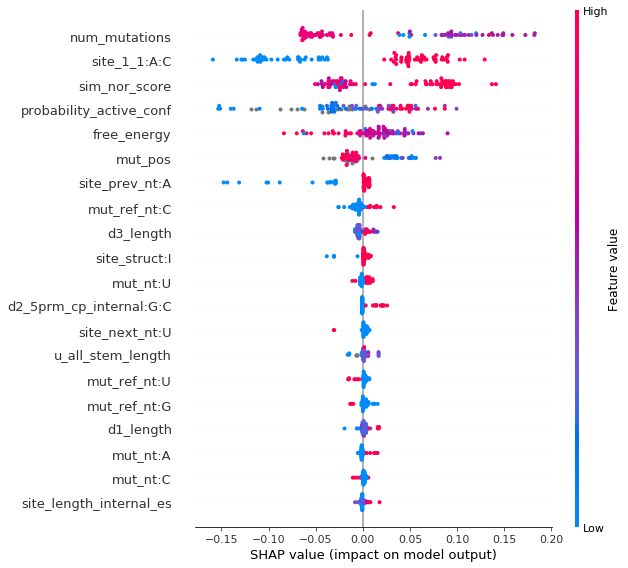

Contribution/Total:0.9840759
['all_stem_length', 'free_energy*', 'sim_nor_score*', 'probability_active_conf*', 'num_mutations*', 'mut_pos*', 'mut_site_dist*', 'mut_ref_nt*', 'mut_nt*', 'mut_struct*', 'mut_ref_struct*', 'mut_prev_struct*', 'mut_next_struct*', 'mut_same_as_site*', 'site_prev_nt*', 'site_next_nt*', 'site_struct*', 'site_prev_struct*', 'site_next_struct*', 'site_1_1*', 'site_length*', 'site_length_stem*', 'site_length_hairpin*', 'site_length_bulge*', 'site_length_internal_es*', 'site_length_internal_ecs*', 'site_5prm_cp_hairpin*', 'site_5prm_cp_bulge*', 'site_3prm_cp_bulge*', 'site_5prm_cp_internal*', 'site_3prm_cp_internal*', 'u_count*', 'u_all_stem_length*', 'u_hairpin_length*', 'u1_exist*', 'u1_distance*', 'u1_struct*', 'u1_length*', 'u1_length_stem*', 'u1_length_hairpin*', 'u1_length_bulge*', 'u1_length_internal_es*', 'u1_length_internal_ecs*', 'u1_5prm_cp_hairpin*', 'u1_5prm_cp_bulge*', 'u1_3prm_cp_bulge*', 'u1_5prm_cp_internal*', 'u1_3prm_cp_internal*', 'u2_exist*', 

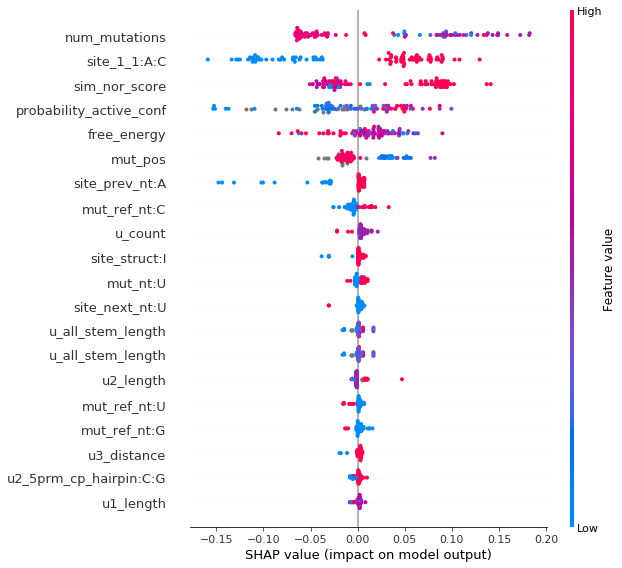

Contribution/Total:0.9822043
['site_struct*', 'site_prev_struct*', 'site_next_struct*', 'site_1_1*', 'site_length*', 'site_length_stem*', 'site_length_hairpin*', 'site_length_bulge*', 'site_length_internal_es*', 'site_length_internal_ecs*', 'site_5prm_cp_hairpin*', 'site_5prm_cp_bulge*', 'site_3prm_cp_bulge*', 'site_5prm_cp_internal*', 'site_3prm_cp_internal*']


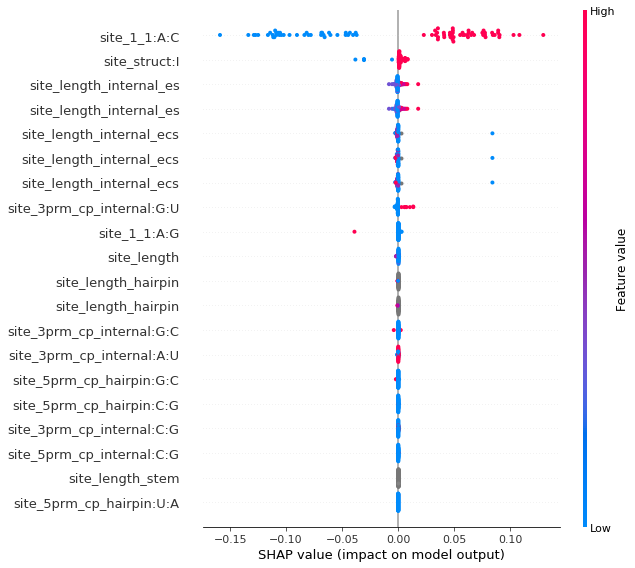

Contribution/Total:0.22535945
['site_prev_nt*', 'site_next_nt*']


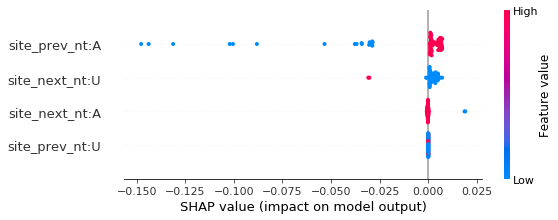

Contribution/Total:0.05295215
['mut_pos*', 'mut_site_dist*', 'mut_ref_nt*', 'mut_nt*']


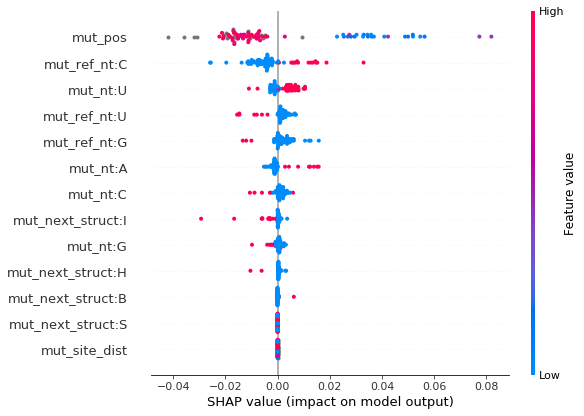

Contribution/Total:0.11520222
['mut_pos*', 'mut_site_dist*', 'mut_ref_nt*', 'mut_nt*', 'site_prev_nt*', 'site_next_nt*']


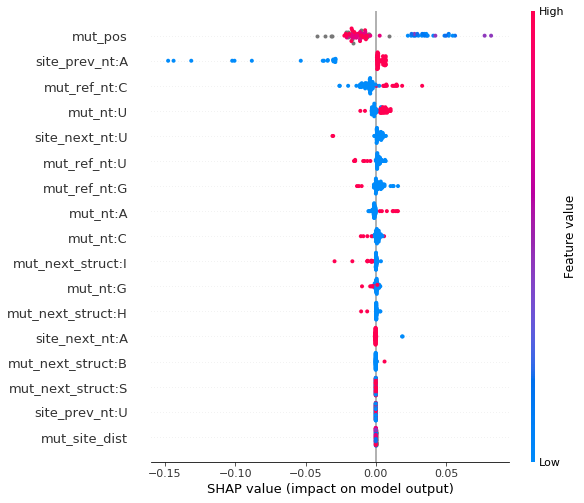

Contribution/Total:0.16815437
['all_stem_length', 'free_energy*', 'sim_nor_score*', 'probability_active_conf*', 'site_prev_nt*', 'site_next_nt*', 'site_struct*', 'site_prev_struct*', 'site_next_struct*', 'site_1_1*', 'site_length*', 'site_length_stem*', 'site_length_hairpin*', 'site_length_bulge*', 'site_length_internal_es*', 'site_length_internal_ecs*', 'site_5prm_cp_hairpin*', 'site_5prm_cp_bulge*', 'site_3prm_cp_bulge*', 'site_5prm_cp_internal*', 'site_3prm_cp_internal*', 'u_count*', 'u_all_stem_length*', 'u_hairpin_length*', 'u1_exist*', 'u1_distance*', 'u1_struct*', 'u1_length*', 'u1_length_stem*', 'u1_length_hairpin*', 'u1_length_bulge*', 'u1_length_internal_es*', 'u1_length_internal_ecs*', 'u1_5prm_cp_hairpin*', 'u1_5prm_cp_bulge*', 'u1_3prm_cp_bulge*', 'u1_5prm_cp_internal*', 'u1_3prm_cp_internal*', 'u2_exist*', 'u2_distance*', 'u2_struct*', 'u2_length*', 'u2_length_stem*', 'u2_length_hairpin*', 'u2_length_bulge*', 'u2_length_internal_es*', 'u2_length_internal_ecs*', 'u2_5prm_c

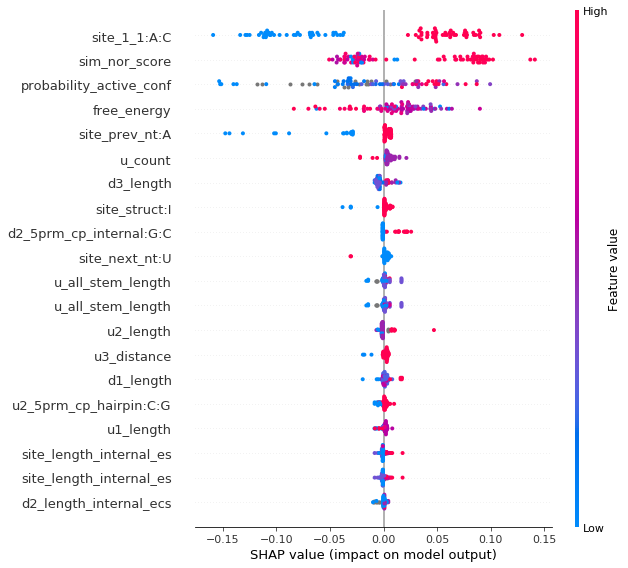

Contribution/Total:0.7138688
['all_stem_length', 'free_energy*', 'sim_nor_score*', 'probability_active_conf*']


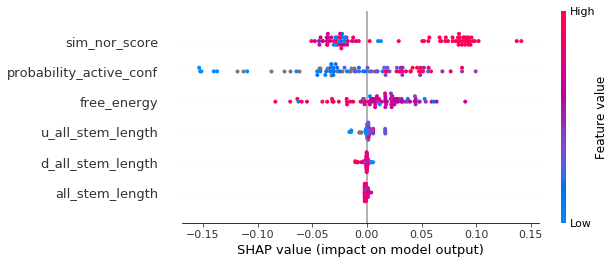

Contribution/Total:0.32850897


In [50]:
from feature_subsets import * 
subset_names=["sub_site_seq","biophysical","u1_d1","mut","site","u","d","u_d","mut_site","no_up","no_down","site_struct","site_seq","mut_seq","mut_seq_site","no_mut","overall_structure"]
subset_contribs=[]
for subset in [sub_site_seq,biophysical, u1_d1,mut,site,u,d,u_d,mut_site,no_up,no_down,site_struct,site_seq,mut_seq,mut_seq_site,no_mut,overall_structure]: 
  print(subset)
  cur_features=filter_features(shap_values,subset)
  cur_feature_shap=shap_values[cur_features].values 
  cur_feature_data_X=test_X[cur_features]
  shap.summary_plot(cur_feature_shap, cur_feature_data_X)#,sort=False,max_display=50)
  contrib=shap_contribs_subgroup(shap_values,subset)
  subset_contribs.append(contrib)
  print("Contribution/Total:"+str(contrib))

In [51]:
subset_contrib_df=pd.DataFrame({'Subset':subset_names,
                               'Contribution':[100*i for i in subset_contribs]})

In [52]:
subset_contrib_df=subset_contrib_df.sort_values(by=['Contribution'],ascending=False)
subset_contrib_df.reset_index(inplace=True, drop=True) 

In [53]:
from pandas.api.types import CategoricalDtype


In [54]:
subset_cat = CategoricalDtype(categories=list(subset_contrib_df['Subset']), ordered=True)

# Cast the existing categories into the new category. Due to a bug in pandas
# we need to do this via a string.
subset_contrib_df['Subset_Cat'] = subset_contrib_df['Subset'].astype(str).astype(subset_cat)


In [55]:
subset_contrib_df

Subset  Contribution         Subset_Cat
0               no_up     98.407590              no_up
1             no_down     98.220432            no_down
2              no_mut     71.386880             no_mut
3            mut_site     60.110700           mut_site
4   overall_structure     32.850897  overall_structure
5                 mut     32.279545                mut
6         biophysical     31.529620        biophysical
7                site     27.831158               site
8         site_struct     22.535945        site_struct
9        mut_seq_site     16.815437       mut_seq_site
10            mut_seq     11.520222            mut_seq
11                u_d     10.704824                u_d
12                  d      5.445990                  d
13           site_seq      5.295215           site_seq
14       sub_site_seq      5.295215       sub_site_seq
15                  u      5.258834                  u
16              u1_d1      1.209861              u1_d1

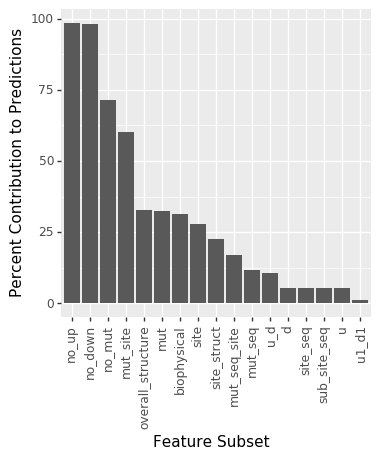

<ggplot: (8742366977689)>

In [56]:
p=(ggplot(subset_contrib_df, aes('Subset_Cat', 'Contribution'))
 + geom_bar(stat='identity')
 + xlab("Feature Subset")
 + ylab("Percent Contribution to Predictions")
 + theme(axis_text_x=element_text(angle=90))
)
ggsave(plot=p, filename='NEIL1.comp.subset.importance.svg',width=5,height=4,units='in')
p

## No "mut" features

In [63]:
## Read in the data 
import feature_subsets
import pandas as pd 
data=pd.read_csv("../xin_feature_matrices/neil1_computational.features.csv",header=0,sep=',',index_col=0)
#drop all mut features
cur_features=filter_features(data,feature_subsets.mut)
cur_features.remove('mut_pos')
data=data.drop(cur_features,axis=1)
data.head


<bound method NDFrame.head of         editing_value  free_energy  sim_nor_score  probability_active_conf  \
rna_id                                                                       
1                0.58       -41.29         0.9930                 0.137610   
2                0.46       -39.30         0.9125                 0.131799   
3                0.49       -40.32         0.9301                 0.065449   
4                0.48       -44.78         1.0000                 0.321958   
5                0.59       -41.45         0.7448                 0.169233   
...               ...          ...            ...                      ...   
290              0.02       -42.93         0.9854                 0.174969   
290              0.02       -42.93         0.9854                 0.174969   
291              0.07       -41.08         0.9740                 0.136266   
291              0.07       -41.08         0.9740                 0.136266   
292              0.66       -44.18

In [64]:
#remove any null editing level values 
data=data[~data["editing_value"].isnull().values]

In [65]:
data=format_for_xgboost(data)
train_split,eval_split,test_split=split_train_test_eval_by_mut_pos(data)

(432, 171)
{20.0: 3, 21.0: 3, 22.0: 4, 23.0: 4, 24.0: 3, 25.0: 4, 26.0: 3, 27.0: 4, 28.0: 4, 29.0: 4, 30.0: 3, 31.0: 4, 32.0: 4, 33.0: 4, 34.0: 4, 35.0: 4, 36.0: 4, 41.0: 21, 42.0: 21, 43.0: 18, 44.0: 17, 45.0: 20, 46.0: 20, 48.0: 20, 49.0: 21, 50.0: 21, 51.0: 20, 52.0: 20, 53.0: 21, 54.0: 19, 55.0: 21, 56.0: 20, 57.0: 15, 58.0: 16, 59.0: 17, nan: 0, nan: 0, nan: 0, nan: 0, nan: 0, nan: 0, nan: 0, nan: 0, nan: 0, nan: 0, nan: 0, nan: 0, nan: 0, nan: 0, nan: 0, nan: 0, nan: 0, nan: 0, nan: 0, nan: 21}


In [66]:
#Remove any non-varying features 
train_novar=get_singleval_features(train_split)
eval_novar=get_singleval_features(eval_split)
test_novar=get_singleval_features(test_split)
uniform_features_to_drop=list(set(train_novar+eval_novar+test_novar))

In [67]:
#Remove any null features 
train_null=get_all_null_features(train_split)
eval_null=get_all_null_features(eval_split)
test_null=get_all_null_features(test_split)
null_features_to_drop=list(set(train_null+eval_null+test_null))

In [68]:
to_drop=list(set(uniform_features_to_drop+null_features_to_drop))
to_drop.append("mut_pos")
print("\n".join(to_drop))

u2_5prm_cp_bulge:A:U
d2_5prm_cp_internal:A:U
d2_exist
d2_5prm_cp_bulge:U:G
d2_length_hairpin
d3_3prm_cp_bulge
site_5prm_cp_bulge:C:G
d2_3prm_cp_internal:G:U
d1_3prm_cp_internal
u1_3prm_cp_bulge
d1_struct:S
d2_3prm_cp_bulge:U:G
d2_5prm_cp_bulge:U:A
d1_5prm_cp_bulge
d3_length_bulge
u3_3prm_cp_internal
d3_3prm_cp_internal
d2_3prm_cp_bulge:G:U
d2_5prm_cp_bulge:A:U
d2_3prm_cp_bulge:U:A
site_5prm_cp_bulge:G:U
u2_3prm_cp_bulge:A:U
u1_length_bulge
d3_struct:S
d1_3prm_cp_bulge
d1_length_internal_es
d1_exist
u2_5prm_cp_internal:G:C
u2_5prm_cp_internal:U:G
d1_length_hairpin
d1_5prm_cp_hairpin
d3_exist
u3_length_hairpin
site_struct:M
u3_length_internal_es
u1_5prm_cp_hairpin
d2_5prm_cp_internal:G:U
site_prev_nt:C
u3_5prm_cp_bulge
u1_length_internal_ecs
d3_length_hairpin
site_5prm_cp_internal:U:G
u1_5prm_cp_bulge
d1_5prm_cp_internal
d1_distance
u2_5prm_cp_bulge:G:U
u3_3prm_cp_bulge
site_next_struct:S
u3_length_internal_ecs
site_5prm_cp_internal:G:C
u3_5prm_cp_hairpin
d3_length_internal_ecs
site_next

In [69]:
train_split=train_split.drop(to_drop,axis=1)
eval_split=eval_split.drop(to_drop,axis=1)
test_split=test_split.drop(to_drop,axis=1)

In [70]:
train_y=train_split['editing_value']
train_X=train_split.drop(['editing_value'],axis=1)

eval_y=eval_split['editing_value']
eval_X=eval_split.drop(['editing_value'],axis=1)

test_y=test_split['editing_value']
test_X=test_split.drop(['editing_value'],axis=1)

In [71]:
print(train_X.shape)
print(train_y.shape)
print(eval_X.shape)
print(eval_y.shape)
print(test_X.shape)
print(test_y.shape)


(283, 95)
(283,)
(89, 95)
(89,)
(102, 95)
(102,)


In [72]:
## format matrixes for xgboost 
import xgboost
dtrain=xgboost.DMatrix(train_X,train_y)
deval=xgboost.DMatrix(eval_X,eval_y)
dtest=xgboost.DMatrix(test_X,test_y)

In [73]:
## set model training parameters 
param=dict() 
param['nthread'] = 20
#rmse -- root mean square error 
# mae -- mean absolute error 
# map -- mean average precision 
# auc -- area under ROC curve 
# aucpr -- area under precision recall curve 
param['eval_metric'] = ['auc','mae','map','aucpr','rmse']

In [74]:
evallist = [(deval, 'eval'), (dtrain, 'train')]


In [75]:
num_round = 1000
bst = xgboost.train(param, dtrain, num_round, evallist,early_stopping_rounds=10)

[0]	eval-auc:0.72501	eval-mae:0.19467	eval-map:1.00000	eval-aucpr:0.47708	eval-rmse:0.23279	train-auc:0.79198	train-mae:0.19318	train-map:1.00000	train-aucpr:0.58099	train-rmse:0.23127
Multiple eval metrics have been passed: 'train-rmse' will be used for early stopping.

Will train until train-rmse hasn't improved in 10 rounds.
[1]	eval-auc:0.74417	eval-mae:0.15867	eval-map:1.00000	eval-aucpr:0.50544	eval-rmse:0.19107	train-auc:0.79705	train-mae:0.15225	train-map:1.00000	train-aucpr:0.58160	train-rmse:0.18038
[2]	eval-auc:0.75406	eval-mae:0.13705	eval-map:1.00000	eval-aucpr:0.53270	eval-rmse:0.16772	train-auc:0.79840	train-mae:0.12344	train-map:1.00000	train-aucpr:0.58045	train-rmse:0.14668
[3]	eval-auc:0.75397	eval-mae:0.11821	eval-map:1.00000	eval-aucpr:0.52751	eval-rmse:0.15102	train-auc:0.80431	train-mae:0.09974	train-map:1.00000	train-aucpr:0.59023	train-rmse:0.11971
[4]	eval-auc:0.75477	eval-mae:0.10597	eval-map:1.00000	eval-aucpr:0.52233	eval-rmse:0.14292	train-auc:0.80670	train

[44]	eval-auc:0.76924	eval-mae:0.05883	eval-map:1.00000	eval-aucpr:0.55212	eval-rmse:0.11940	train-auc:0.82183	train-mae:0.01559	train-map:1.00000	train-aucpr:0.62243	train-rmse:0.03036
[45]	eval-auc:0.76936	eval-mae:0.05855	eval-map:1.00000	eval-aucpr:0.55182	eval-rmse:0.11936	train-auc:0.82188	train-mae:0.01500	train-map:1.00000	train-aucpr:0.62256	train-rmse:0.02995
[46]	eval-auc:0.76949	eval-mae:0.05847	eval-map:1.00000	eval-aucpr:0.55190	eval-rmse:0.11942	train-auc:0.82190	train-mae:0.01481	train-map:1.00000	train-aucpr:0.62257	train-rmse:0.02984
[47]	eval-auc:0.76952	eval-mae:0.05823	eval-map:1.00000	eval-aucpr:0.55191	eval-rmse:0.11936	train-auc:0.82193	train-mae:0.01460	train-map:1.00000	train-aucpr:0.62263	train-rmse:0.02975
[48]	eval-auc:0.76964	eval-mae:0.05810	eval-map:1.00000	eval-aucpr:0.55326	eval-rmse:0.11933	train-auc:0.82194	train-mae:0.01452	train-map:1.00000	train-aucpr:0.62269	train-rmse:0.02968
[49]	eval-auc:0.76928	eval-mae:0.05806	eval-map:1.00000	eval-aucpr:0.5

[89]	eval-auc:0.76976	eval-mae:0.05505	eval-map:1.00000	eval-aucpr:0.55359	eval-rmse:0.11940	train-auc:0.82224	train-mae:0.00952	train-map:1.00000	train-aucpr:0.62343	train-rmse:0.02786
[90]	eval-auc:0.76969	eval-mae:0.05502	eval-map:1.00000	eval-aucpr:0.55287	eval-rmse:0.11944	train-auc:0.82223	train-mae:0.00942	train-map:1.00000	train-aucpr:0.62343	train-rmse:0.02785
[91]	eval-auc:0.76978	eval-mae:0.05500	eval-map:1.00000	eval-aucpr:0.55297	eval-rmse:0.11949	train-auc:0.82223	train-mae:0.00937	train-map:1.00000	train-aucpr:0.62343	train-rmse:0.02784
[92]	eval-auc:0.76972	eval-mae:0.05497	eval-map:1.00000	eval-aucpr:0.55294	eval-rmse:0.11945	train-auc:0.82224	train-mae:0.00932	train-map:1.00000	train-aucpr:0.62344	train-rmse:0.02783
[93]	eval-auc:0.76964	eval-mae:0.05493	eval-map:1.00000	eval-aucpr:0.55281	eval-rmse:0.11945	train-auc:0.82224	train-mae:0.00930	train-map:1.00000	train-aucpr:0.62344	train-rmse:0.02783
[94]	eval-auc:0.76963	eval-mae:0.05493	eval-map:1.00000	eval-aucpr:0.5

In [76]:
# save to binary file for faster loading
bst.save_model('neil1.computational.model')
# save model to text file 
bst.dump_model('neil1.computational.raw.txt')


In [77]:
## get model predictions on the test, training, and eval splits 
test_pred = bst.predict(dtest)
train_pred=bst.predict(dtrain)
eval_pred=bst.predict(deval)

In [78]:
## Correlation values 
from scipy.stats import spearmanr,pearsonr
spearman_train=spearmanr(train_y,train_pred)
spearman_eval=spearmanr(eval_y,eval_pred)
spearman_test=spearmanr(test_y,test_pred)

pearson_train=pearsonr(train_y,train_pred)
pearson_eval=pearsonr(eval_y,eval_pred)
pearson_test=pearsonr(test_y,test_pred)

print("Spearman correlation:")
print("Train:"+str(spearman_train))
print("Eval:"+str(spearman_eval))
print("Test:"+str(spearman_test))
print("\n")
print("Pearson correlation:")
print("Train:"+str(pearson_train))
print("Eval:"+str(pearson_eval))
print("Test:"+str(pearson_test))

Spearman correlation:
Train:SpearmanrResult(correlation=0.9941262850174096, pvalue=2.1244539160179577e-273)
Eval:SpearmanrResult(correlation=0.8596396033367235, pvalue=4.17061949234322e-27)
Test:SpearmanrResult(correlation=0.7885494696159702, pvalue=7.70831143768869e-23)


Pearson correlation:
Train:(0.993590980858163, 4.2959070899506256e-268)
Eval:(0.856690767008713, 9.64838411320139e-27)
Test:(0.8084107406870898, 9.427678379736434e-25)


In [79]:
## MAE
from sklearn.metrics import mean_absolute_error
mae_train=mean_absolute_error(train_y,train_pred)
print("MAE Train:"+str(mae_train))

mae_eval=mean_absolute_error(eval_y,eval_pred)
print("MAE Eval:"+str(mae_eval))

mae_test=mean_absolute_error(test_y,test_pred)
print("MAE Test:"+str(mae_test))


MAE Train:0.0090630616525323
MAE Eval:0.05478357583619235
MAE Test:0.05375194578778509


In [80]:
## MAPE
pseudocount=0.01
mape_train=np.mean(np.abs((train_y - train_pred) /(pseudocount+train_y))) * 100
print("MAPE Train:"+str(mape_train)+"%")

mape_eval=np.mean(np.abs((eval_y - eval_pred) /(pseudocount+eval_y))) * 100
print("MAPE Eval:"+str(mape_eval)+"%")

mape_test=np.mean(np.abs((test_y - test_pred) /(pseudocount+test_y))) * 100
print("MAPE Test:"+str(mape_test)+"%")

MAPE Train:3.4719713091251965%
MAPE Eval:52.186170764547235%
MAPE Test:107.82155693083652%


In [81]:
## RMSE
from sklearn.metrics import mean_squared_error
import math 
rmse_train=math.sqrt(mean_squared_error(train_y,train_pred))
print("RMSE Train:"+str(rmse_train))

rmse_eval=math.sqrt(mean_squared_error(eval_y,eval_pred))
print("RMSE Eval:"+str(rmse_eval))

rmse_test=math.sqrt(mean_squared_error(test_y,test_pred))
print("RMSE Test:"+str(rmse_test))


RMSE Train:0.02779887525328498
RMSE Eval:0.11944013340874149
RMSE Test:0.12357240354992417


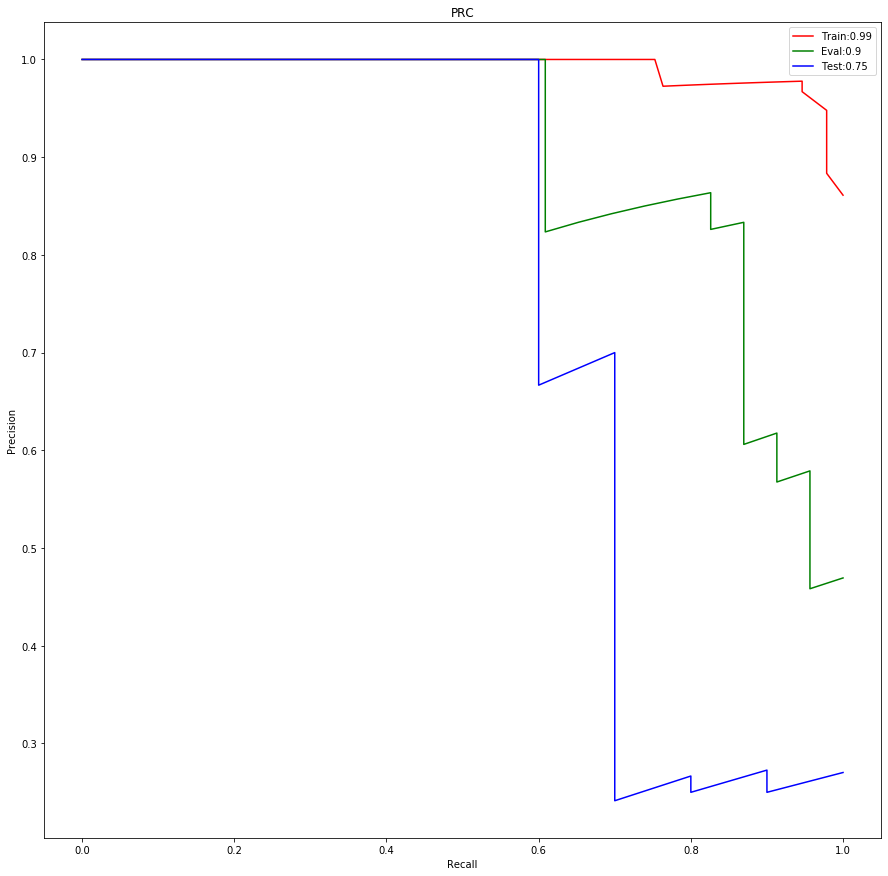

In [82]:
## PRC 
## PRC only valid for binary outcomes. 
## Editing levels < 0.5 are labeled as "0". 
## Editing levels >= 0.5 are labeled as "1". 

from sklearn.metrics import auc, precision_recall_curve

precision_train,recall_train,prc_thresholds_train=precision_recall_curve(train_y>=0.5,train_pred)
precision_eval,recall_eval,prc_thresholds_eval=precision_recall_curve(eval_y>=0.5,eval_pred)
precision_test,recall_test,prc_thresholds_test=precision_recall_curve(test_y>=0.5,test_pred)

auprc_train=auc(recall_train,precision_train)
auprc_eval=auc(recall_eval,precision_eval)
auprc_test=auc(recall_test,precision_test)

plt.plot(recall_train,precision_train,'r',label="Train:"+str(round(auprc_train,2)))
plt.plot(recall_eval,precision_eval,'g',label="Eval:"+str(round(auprc_eval,2)))
plt.plot(recall_test,precision_test,'b',label="Test:"+str(round(auprc_test,2)))
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("PRC")
plt.legend()

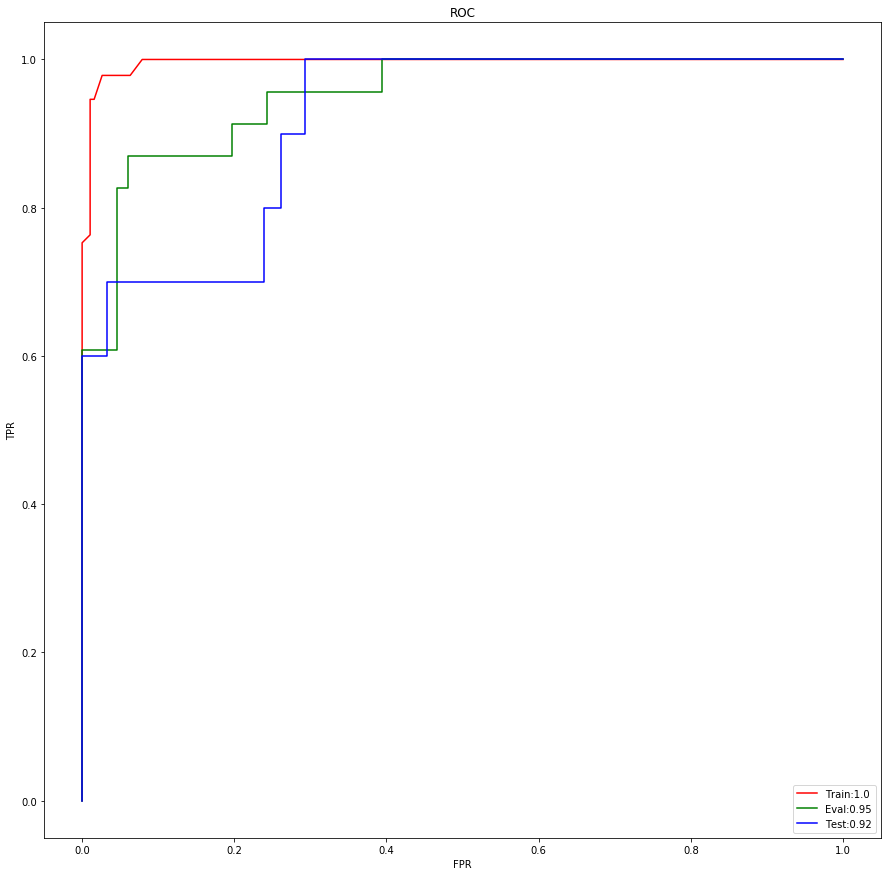

In [83]:
## ROC
from sklearn.metrics import roc_curve, roc_auc_score
fpr_train,tpr_train,roc_thresholds_train=roc_curve(train_y>=0.5,train_pred)
fpr_eval,tpr_eval,roc_thresholds_eval=roc_curve(eval_y>=0.5,eval_pred)
fpr_test,tpr_test,roc_thresholds_test=roc_curve(test_y>=0.5,test_pred)

auroc_train=roc_auc_score(train_y>=0.5,train_pred)
auroc_eval=roc_auc_score(eval_y>=0.5,eval_pred)
auroc_test=roc_auc_score(test_y>=0.5,test_pred)

plt.plot(fpr_train,tpr_train,'r',label="Train:"+str(round(auroc_train,2)))
plt.plot(fpr_eval,tpr_eval,'g',label="Eval:"+str(round(auroc_eval,2)))
plt.plot(fpr_test,tpr_test,'b',label="Test:"+str(round(auroc_test,2)))
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC")
plt.legend()

In [84]:
#plot the test set predictions 
matplotlib.rcParams['figure.figsize'] = [20, 8]
plt.subplot(1,3,1)
plt.plot(list(train_y),list(train_pred),'o')
plt.xlabel("Observed train set editing level, Neil 1 Degenerate")
plt.ylabel("Predicted train set editing level, Neil 1 Degenerate")
plt.subplot(1,3,2)
plt.plot(list(eval_y),list(eval_pred),'o')
plt.xlabel("Observed eval set editing level, Neil 1 Degenerate")
plt.ylabel("Predicted eval set editing level, Neil 1 Degenerate")
plt.subplot(1,3,3)
plt.plot(list(test_y),list(test_pred),'o')
plt.xlabel("Observed test set editing level, Neil 1 Degenerate")
plt.ylabel("Predicted test set editing level, Neil 1 Degenerate")

plt.show()

AttributeError: 'bool' object has no attribute 'rcParams'

In [ ]:
matplotlib.rcParams['figure.figsize'] = [15, 15]
xgboost.plot_importance(bst)

In [ ]:
xgboost.to_graphviz(bst, num_trees=2)


In [85]:
# explain the model's predictions using SHAP values
explainer = shap.TreeExplainer(bst)
shap_values = explainer.shap_values(test_X)
shap_values.shape

(102, 95)

In [86]:
test_y=pd.DataFrame(test_y)
max_index=test_y.index[test_y['editing_value'] == max(test_y['editing_value'])]
max_row=test_y.index.get_loc(max_index[0])
# visualize prediction for isoform with the highest editing level 
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[max_row,:], test_X.iloc[max_row,:])

In [87]:
# visualize prediction for isoform with the lowest editing level 
shap.initjs()
min_index=test_y.index[test_y['editing_value'] == min(test_y['editing_value'])]
min_row=test_y.index.get_loc(min_index[0])
shap.force_plot(explainer.expected_value, shap_values[min_row,:], test_X.iloc[min_row,:])

In [88]:
# visualize the training set predictions
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values,train_X)

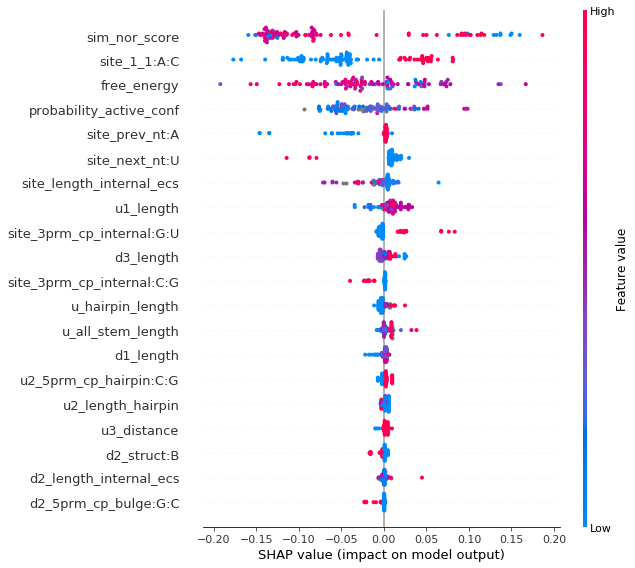

In [89]:
# summarize the effect of all the features 
shap.summary_plot(shap_values, test_X)


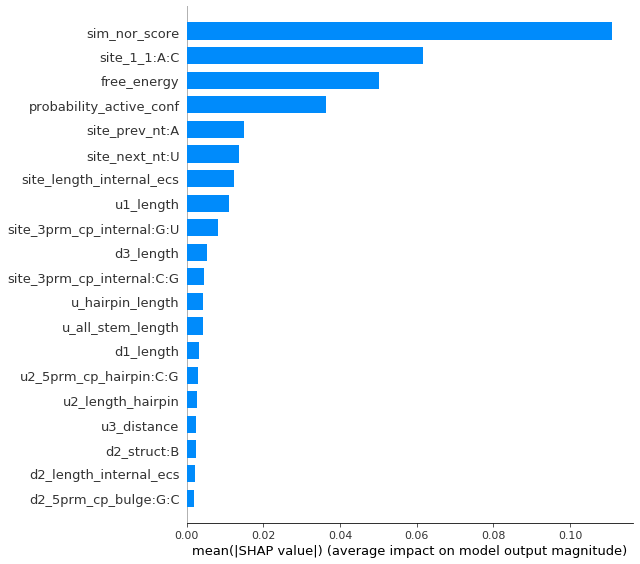

In [90]:
# We can also just take the mean absolute value of the SHAP values for each feature 
# to get a standard bar plot (produces stacked bars for multi-class outputs):
shap.summary_plot(shap_values, test_X, plot_type="bar")

In [91]:
## Compute pairwise interaction values from TreeShap
shap_interaction_values=explainer.shap_interaction_values(test_X)
shap_interaction_values.shape

(102, 95, 95)

In [92]:
##Average interaction values across the datapoints in the test set 
mean_interaction_values=np.mean(shap_interaction_values,axis=0)

In [93]:
Index=test_X.columns
Cols=test_X.columns
mean_interaction_values_df = pd.DataFrame(mean_interaction_values, index=Index, columns=Cols)

In [94]:
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)
configure_plotly_browser_state()

trace = Heatmap(z=mean_interaction_values_df.values,
                   x=Cols,
                   y=Index)
iplot([trace],show_link=False)
